# Fake News Detection from articles
- ![](https://www.geo.tv/assets/uploads/updates/2018-07-18/l_203781_040549_updates.jpg)
- Some fake articles have relatively frequent use of
terms seemingly intended to inspire outrage and the
present writing skill in such articles is generally
considerably lesser than in standard news.

## Importing libraries

In [0]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import requests
import bs4
from bs4 import BeautifulSoup
import ipywidgets as widgets
from IPython.display import display
from google.colab.patches import cv2_imshow
from IPython.display import Image,display
fake = Image('https://techcrunch.com/wp-content/uploads/2017/09/fake-news.jpg')
real = Image('https://thumbs.dreamstime.com/b/heres-real-news-42097069.jpg')

In [0]:
!pip install transformers
!pip install pytorch_pretrained_bert

     |████████████████████████████████| 501kB 2.8MB/s 
     |████████████████████████████████| 1.0MB 45.9MB/s 
     |████████████████████████████████| 3.7MB 33.5MB/s 
     |████████████████████████████████| 870kB 46.7MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.38-cp36-none-any.whl size=884628 sha256=1b04df988028a2600c95de310ed49ce805b531dcca6e758f0f9d9e991363a919
  Stored in directory: /root/.cache/pip/wheels/6d/ec/1a/21b8912e35e02741306f35f66c785f3afe94de754a0eaf1422
Successfully built sacremoses
     |████████████████████████████████| 133kB 2.8MB/s 


In [0]:
import torch.nn as nn
import torch
from pytorch_pretrained_bert import BertTokenizer, BertModel
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report

Using TensorFlow backend.


## Model

## Description
- Used [BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/abs/1810.04805) with fine tuning
- BERT, which stands for Bidirectional Encoder Representations from Transformers.
- BERT is designed to pretrain deep bidirectional representations from
unlabeled text by jointly conditioning on both
left and right context in all layers. As a result, the pre-trained BERT model can be finetuned with just one additional output layer
to create state-of-the-art models for a wide
range of tasks, such as question answering and
language inference, without substantial taskspecific architecture modifications.
- ![](https://github.com/manideep2510/siamese-BERT-fake-news-detection-LIAR/blob/master/doc_images/bert.png?raw=true)

#### Code

In [0]:
class BertBinaryClassifier(nn.Module):
    def __init__(self, dropout=0.1):
        super(BertBinaryClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, tokens, masks=None):
        _, pooled_output = self.bert(tokens, attention_mask=masks, output_all_encoded_layers=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        proba = self.sigmoid(linear_output)
        return proba

## Preprocessing
- Used [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/) for scraping articles from the web, Beautiful Soup is a Python library designed for quick turnaround projects like screen-scraping
- Also used some custom made functions for removing punctuation etc.
-![](https://miro.medium.com/max/495/1*AaAIETIq7XNlLrFQW7BtZg.png)

### code

In [0]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

100%|██████████| 231508/231508 [00:00<00:00, 425602.25B/s]


In [0]:
def Punctuation(string): 
  
    # punctuation marks 
    punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
  
    # traverse the given string and if any punctuation 
    # marks occur replace it with null 
    for x in string.lower(): 
        if x in punctuations: 
            string = string.replace(x, "") 
  
    # return string without punctuation 
    return string

In [0]:
def get_text(url):
    try:
        result=requests.get(str(url))
    except Exception:
        print("error in scraping url")
        return None
    src=result.content
    soup=BeautifulSoup(src,'lxml')   
    text=[]	
    for p_tag in soup.find_all('p'):
        text.append(p_tag.text)
    text = Punctuation(str(text))
    return text

## Testing

In [0]:
# drive_link = 'https://drive.google.com/open?id=108JY7_yROQQsJDFbusVPP1aUmkZ4xe16'

In [0]:
path='/content/drive/My Drive/fake_news/nb_state256.pth'
#weights_url = 'https://drive.google.com/open?id=1r-XIJBfW3EZT6rIqE5kQD96hJb4MoEj7'
model = BertBinaryClassifier()
# optimizer = torch.optim.Adam(model.parameters(), lr=3e-6)
model.load_state_dict(torch.load(path))
model.eval()

100%|██████████| 407873900/407873900 [00:35<00:00, 11336946.19B/s]


BertBinaryClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            

In [0]:
def test(article,model):
    bert_predicted = []
    all_logits = []
    test_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:255], [article]))
    test_tokens_ids = list(map(tokenizer.convert_tokens_to_ids, test_tokens))
    test_tokens_ids = pad_sequences(test_tokens_ids, maxlen=256, truncating="post", padding="post", dtype="int")
    test_masks = [[float(i > 0) for i in ii] for ii in test_tokens_ids]
    test_masks_tensor = torch.tensor(test_masks)
    test_tokens_ids = torch.tensor(test_tokens_ids)
    with torch.no_grad():
        logits = model(test_tokens_ids, test_masks_tensor)
        numpy_logits = logits.cpu().detach().numpy()
        if(numpy_logits[0,0] > 0.5):
            return 'Fake'
        else:
            return 'True'

In [0]:
def answer(url,model):
    article = get_text(url)
    ans = test(article,model)
    return ans

## Inference

- Enter the url to test , Add press Shift+Enter for results.

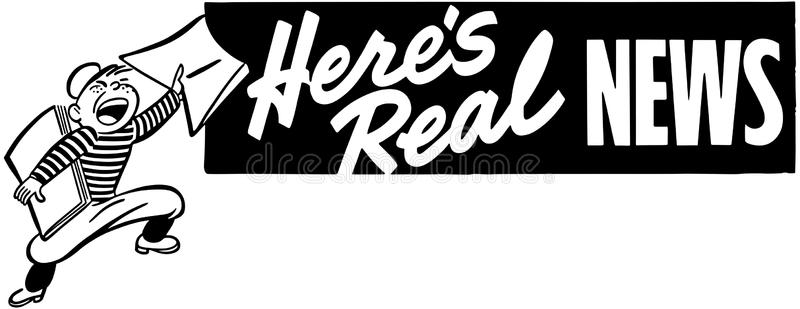

In [0]:
#@title Fake Article Detection

url = 'https://www.thespoof.com/spoof-news/entertainment-gossip/147299/joe-rogan-experience-guest-advises-listeners-that-things-to-do-before-they-die-should-be-done-without-further-delay' #@param {type:"string"}
# button = widgets.Button(description="Enter")
# output = widgets.Output()
# display(button, output)
#print(answer(url,model))
if (answer(url,model)=='True'):
    display(real)
else:
    display(fake)